In [ ]:
#####  TO GET A<121 NUCLEI FILE 
import pandas as pd

# ============================
# LOAD FILE
# ============================

input_file = "FRDM_AME_features_A_bous_with_local_stats.xlsx"
df = pd.read_excel(input_file)

print("Original number of nuclei:", len(df))

# ============================
# FILTER A < 121
# ============================

df_filtered = df[df["A"] < 121].copy()

print("Number of nuclei with A < 121:", len(df_filtered))

# ============================
# SAVE OUTPUT
# ============================

output_file = "A<121_nuclei_all.xlsx"
df_filtered.to_excel(output_file, index=False)

print(f"Saved file as: {output_file}")

Original number of nuclei: 2431
Number of nuclei with A < 121: 1003
Saved file as: A<121_nuclei_all.xlsx


In [ ]:
##### SPLIT THEM INTO 22 GROUPS 

# ==========================================================
# RANDOM SPLIT INTO 22 GROUPS (A < 121)
# ==========================================================

import os
import numpy as np
import pandas as pd

# ----------------------------------------------------------
# CONFIG
# ----------------------------------------------------------

INPUT_FILE = "A<121_nuclei_all.xlsx"
OUTPUT_DIR = "splits"
OUTPUT_FILE = f"{OUTPUT_DIR}/random_22_groups.xlsx"

N_GROUPS = 22
SEED = 42   # for reproducibility

# ----------------------------------------------------------
# LOAD DATA
# ----------------------------------------------------------

df = pd.read_excel(INPUT_FILE)[["Z", "N", "A"]].copy()

# Apply A < 121 cut
df = df[df["A"] < 121].reset_index(drop=True)

print("===================================================")
print("RANDOM SPLIT INTO 22 GROUPS (A < 121)")
print("===================================================")
print(f"Total nuclei with A <121: {len(df)}")
print("---------------------------------------------------")

# ----------------------------------------------------------
# RANDOM SHUFFLE
# ----------------------------------------------------------

rng = np.random.default_rng(SEED)
perm = rng.permutation(len(df))
df = df.loc[perm].reset_index(drop=True)

# ----------------------------------------------------------
# ASSIGN GROUPS EVENLY
# ----------------------------------------------------------

group_ids = np.zeros(len(df), dtype=int)

sizes = [len(df) // N_GROUPS] * N_GROUPS
for i in range(len(df) % N_GROUPS):
    sizes[i] += 1

start = 0
for g, sz in enumerate(sizes, start=1):
    group_ids[start:start+sz] = g
    start += sz

df["group"] = group_ids

# ----------------------------------------------------------
# SAVE
# ----------------------------------------------------------

os.makedirs(OUTPUT_DIR, exist_ok=True)
df[["Z", "N", "group"]].to_excel(OUTPUT_FILE, index=False)

# ----------------------------------------------------------
# PRINT OUTPUT SUMMARY
# ----------------------------------------------------------

print("\nGroup sizes:")
print(df["group"].value_counts().sort_index())

print("\nSaved splits to:", OUTPUT_FILE)
print("===================================================")


RANDOM SPLIT INTO 22 GROUPS (A < 121)
Total nuclei with A <121: 1003
---------------------------------------------------

Group sizes:
group
1     46
2     46
3     46
4     46
5     46
6     46
7     46
8     46
9     46
10    46
11    46
12    46
13    46
14    45
15    45
16    45
17    45
18    45
19    45
20    45
21    45
22    45
Name: count, dtype: int64

Saved splits to: splits/random_22_groups.xlsx


In [ ]:
##### TRAIN OVER THEM
import sys

print("Notebook Python:", sys.executable)

for i in range(1, 23):
    print("\n" + "="*60)
    print(f"RUNNING GROUP {i}")
    print("="*60)
    !{sys.executable} bin_all.py {i}

Notebook Python: /opt/homebrew/opt/python@3.11/bin/python3.11

RUNNING GROUP 1
/opt/homebrew/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
Process ID: 4352

MAJOR RUN — TEST GROUP 1

L2 STEP 1 | L2 = 1.00000000e-01
Epochs used: 27
Train RMSE: 0.826370
Test  RMSE: 0.748551

L2 STEP 2 | L2 = 9.90000000e-02
Epochs used: 27
Train RMSE: 0.826373
Test  RMSE: 0.748551

L2 STEP 3 | L2 = 9.80000000e-02
Epochs used: 27
Train RMSE: 0.826365
Test  RMSE: 0.748552

L2 STEP 4 | L2 = 9.70000000e-02
Epochs used: 27
Train RMSE: 0.826367
Test  RMSE: 0.748552

L2 STEP 5 | L2 = 9.60000000e-02
Epochs used: 27
Train RMSE: 0.826353
Test  RMSE: 0.748555

L2 STEP 6 | L2 = 9.50000000e-02
Epochs used: 27
Train RMSE: 0.826337
Test  RMSE: 0.748558

L2 STEP 7 | L2 = 9.40000000e-02
Epochs used: 27
Train RMSE: 0.826336
Test  RMSE: 0.748559

L2 STEP 8 | L2 = 9.30000000e-02
Epochs

Total nuclei: 1003


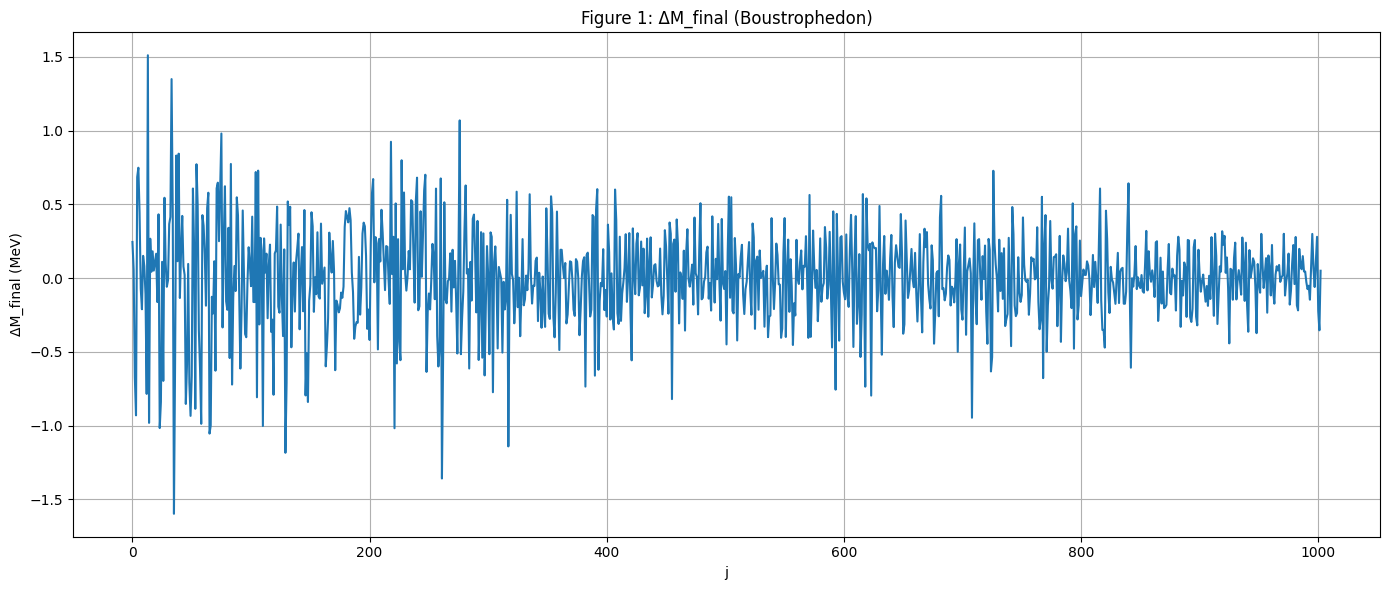

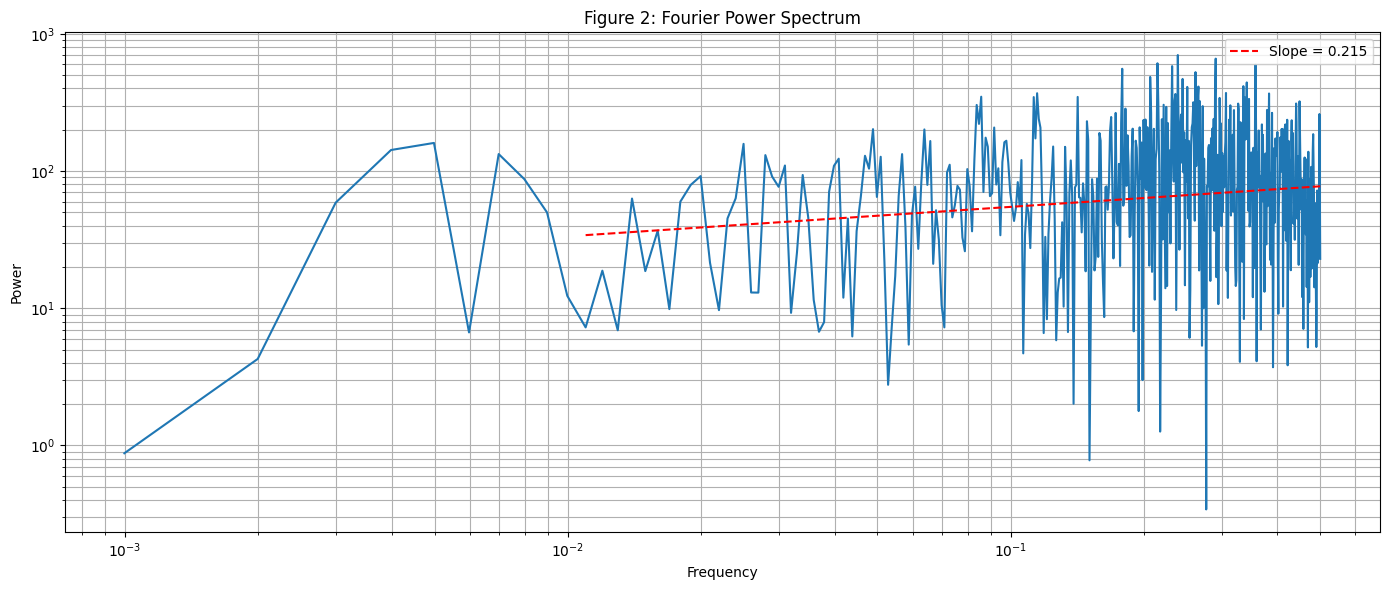


Spectral slope = 0.2146
R^2 = 0.0216


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.stats import linregress
import os

# ============================================================
# LOAD ALL GROUP FILES
# ============================================================

all_dfs = []

for i in range(1, 23):
    file_path = f"results_residual_ffnn_singlebin/Test_Group_{i}_Final.xlsx"
    
    if os.path.exists(file_path):
        df_i = pd.read_excel(file_path)
        all_dfs.append(df_i)

df_all = pd.concat(all_dfs, ignore_index=True)

print("Total nuclei:", len(df_all))

# ============================================================
# BOUSTROPHEDON (|N-Z| BASED)
# ============================================================

def boustrophedon_sort(df):

    df = df.copy()
    df["abs_N_minus_Z"] = np.abs(df["N"] - df["Z"])

    ordered_blocks = []

    for A_val in sorted(df["A"].unique()):

        df_A = df[df["A"] == A_val]

        if A_val % 2 == 0:
            df_A = df_A.sort_values("abs_N_minus_Z", ascending=True)
        else:
            df_A = df_A.sort_values("abs_N_minus_Z", ascending=False)

        ordered_blocks.append(df_A)

    df_final = pd.concat(ordered_blocks, ignore_index=True)
    df_final.drop(columns=["abs_N_minus_Z"], inplace=True)

    return df_final

df_bous = boustrophedon_sort(df_all)

delta = df_bous["deltaMi_final"].values
N = len(delta)

# ============================================================
# FIGURE 1
# ============================================================

plt.figure(figsize=(14,6))
plt.plot(delta)
plt.title("Figure 1: ΔM_final (Boustrophedon)")
plt.xlabel("j")
plt.ylabel("ΔM_final (MeV)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# FIGURE 2
# ============================================================

delta_centered = delta - np.mean(delta)
fft_vals = fft(delta_centered)
power = np.abs(fft_vals)**2
freqs = np.fft.fftfreq(N)

mask = freqs > 0
freqs = freqs[mask]
power = power[mask]

fit_mask = freqs > 0.01

log_f = np.log10(freqs[fit_mask])
log_p = np.log10(power[fit_mask])

slope, intercept, r_value, _, _ = linregress(log_f, log_p)

fit_line = 10**(intercept + slope * log_f)

plt.figure(figsize=(14,6))
plt.loglog(freqs, power)
plt.loglog(freqs[fit_mask], fit_line, 'r--',
           label=f"Slope = {slope:.3f}")
plt.title("Figure 2: Fourier Power Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nSpectral slope = {slope:.4f}")
print(f"R^2 = {r_value**2:.4f}")

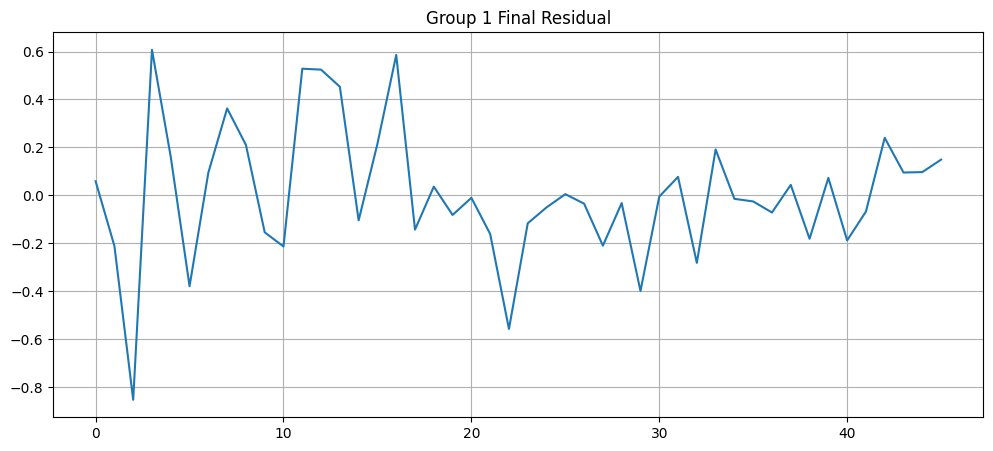

In [ ]:
#####CAN CHECK THE PLOTS
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel("results_residual_ffnn_singlebin/Test_Group_1_Final.xlsx")

plt.figure(figsize=(12,5))
plt.plot(df["deltaMi_final"])
plt.title("Group 1 Final Residual")
plt.grid(True)
plt.show()

In [1]:
#####FIND HOW MANY GOOD NUCLEI
import pandas as pd
import numpy as np
import glob
import os

# ============================================================
# FOLDER WHERE YOUR 22 FILES ARE SAVED
# ============================================================

results_folder = "results_residual_ffnn_singlebin"

# Find all Test_Group files
file_list = sorted(
    glob.glob(os.path.join(results_folder, "Test_Group_*_Final.xlsx"))
)

print(f"Found {len(file_list)} group files")

# ============================================================
# LOAD AND CONCATENATE ALL FILES
# ============================================================

all_dfs = []

for file in file_list:
    df = pd.read_excel(file)
    all_dfs.append(df)

combined_df = pd.concat(all_dfs, ignore_index=True)

print("Total nuclei combined:", len(combined_df))

# ============================================================
# COMPUTE COUNTS FOR THRESHOLDS
# ============================================================

thresholds = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.1]

print("\nCounts for |deltaMi_final| > threshold:\n")

for t in thresholds:
    count = np.sum(np.abs(combined_df["deltaMi_final"]) > t)
    print(f"|deltaMi_final| > {t:.1f} MeV  :  {count}")

Found 22 group files
Total nuclei combined: 1003

Counts for |deltaMi_final| > threshold:

|deltaMi_final| > 1.0 MeV  :  11
|deltaMi_final| > 0.9 MeV  :  19
|deltaMi_final| > 0.8 MeV  :  27
|deltaMi_final| > 0.7 MeV  :  46
|deltaMi_final| > 0.6 MeV  :  76
|deltaMi_final| > 0.5 MeV  :  120
|deltaMi_final| > 0.4 MeV  :  193
|deltaMi_final| > 0.3 MeV  :  288
|deltaMi_final| > 0.1 MeV  :  710


In [1]:
#####REMOVE BAD NUCLEI AND GIVE THE FINAL FILE TO BE USED FOR PREDICTION
import pandas as pd
import numpy as np
import glob
import os

# ============================================================
# STEP 1 — LOAD ALL TEST GROUP RESULT FILES
# ============================================================

results_folder = "results_residual_ffnn_singlebin"

file_list = sorted(
    glob.glob(os.path.join(results_folder, "Test_Group_*_Final.xlsx"))
)

all_results = []

for file in file_list:
    df = pd.read_excel(file)
    all_results.append(df)

combined_results = pd.concat(all_results, ignore_index=True)

print("Total nuclei in prediction results:", len(combined_results))

# ============================================================
# STEP 2 — REMOVE NUCLEI WITH |deltaMi_final| > 0.26
# ============================================================

threshold = 50

filtered_results = combined_results[
    np.abs(combined_results["deltaMi_final"]) <= threshold
].copy()

print("Nuclei remaining after threshold cut:", len(filtered_results))

# ============================================================
# STEP 3 — LOAD FULL FEATURE FILE
# ============================================================

full_features = pd.read_excel("A<121_nuclei_all.xlsx")

print("Total nuclei in A<121_nuclei_all:", len(full_features))

# ============================================================
# STEP 4 — MERGE TO KEEP ONLY SURVIVING NUCLEI
# ============================================================

# Merge on Z and N
final_df = full_features.merge(
    filtered_results[["Z", "N", "deltaMi_final"]],
    on=["Z", "N"],
    how="inner"
)

print("Final nuclei after merging:", len(final_df))

# ============================================================
# STEP 5 — SAVE FINAL FILE
# ============================================================

output_file = "A<121_nuclei_pred.xlsx"
final_df.to_excel(output_file, index=False)

print(f"Saved file as: {output_file}")

Total nuclei in prediction results: 1003
Nuclei remaining after threshold cut: 1003
Total nuclei in A<121_nuclei_all: 1003
Final nuclei after merging: 1003
Saved file as: A<121_nuclei_pred.xlsx


In [ ]:
#####USE THE PREDICTION FILE TO DO THE RESIDUAL BASED LEARNING 